# Performance Evaluation
This notebook is for general illustration purposes only. Performance may vary significantly compared to a dedicated *python run.py* call

In [1]:
import os
import numpy as np

from pyGNG import GrowingNeuralGas
import networkx as nx
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd
import seaborn as sns
import subprocess

%matplotlib inline

Load data. Encoded word vectors from Google News - 3M examples, 300 features each. 

In [2]:
# GoogleNews Word2Vec vectors
train_data = np.load("data/googlenews/GoogleNews-vectors-negative300.npy")
train_data = torch.Tensor(train_data).float()

###########################################################################
# Scale
train_data = train_data - train_data.min()
train_data = train_data / train_data.max()

###########################################################################

assert train_data.min() == 0 and train_data.max() == 1
print(f'Data shape: {train_data.shape}')

Data shape: torch.Size([3000000, 300])


Of course, the performance depends heavily on the hardware on which the notebook is running. However, this notebook runs on for demonstration purposes:

In [3]:
torch.cuda.get_device_name(device=None)

'NVIDIA A100-SXM4-80GB'

respectivly with the following CPU setup:

In [4]:
print((subprocess.check_output("lscpu", shell=True).strip()).decode().split("BogoMIPS")[0])

Architecture:                       x86_64
CPU op-mode(s):                     32-bit, 64-bit
Address sizes:                      43 bits physical, 48 bits virtual
Byte Order:                         Little Endian
CPU(s):                             256
On-line CPU(s) list:                0-255
Vendor ID:                          AuthenticAMD
Model name:                         AMD EPYC 7742 64-Core Processor
CPU family:                         23
Model:                              49
Thread(s) per core:                 2
Core(s) per socket:                 64
Socket(s):                          2
Stepping:                           0
Frequency boost:                    enabled
CPU max MHz:                        2250.0000
CPU min MHz:                        1500.0000



However, as this instance runs on a virtual machine, just a limited number of cores are exposed to the virtual host system:

In [5]:
available_cores = len(os.sched_getaffinity(0))
print(f'Available CPU cores: {len(os.sched_getaffinity(0))}')

Available CPU cores: 12


The frequency of node and edge removal depends heavily on the dataset. However, the removal of nodes and edges only has a minor impact on performance, which is why it is deactivated in this performance demonstration.

In [ ]:
# Evaluate performance for the following GNG sizes
gng_sizes = [50,100,200,500,1000,2000,5000,10000,25000]
#gng_sizes = [5000,10000,100000]
device = ["cuda", "cpu"]
#device = ["cpu"]
batch_size = [128,512,2048,4096]

# Keep all other parameters constant
dataset_name = "Google News"
random_seed = 42
gng_max_edge_age = np.inf     # Disable edge removal
gng_max_node_error = np.inf   # Disable node removal. 
epochs = 10
save_progress = True
save_path = "./trials/"
torch_num_threads = available_cores+2

for i, (d, gs, bs) in enumerate(product(device, gng_sizes, batch_size)):
    if d == "cuda": continue
    train_data = train_data.to(d)
    
    
    gng = GrowingNeuralGas(n_features = train_data.shape[1],
                           initial_gng_size = gs,
                           max_gng_size = gs,
                           batch_size = bs,
                           random_seed = random_seed,
                           device = d,
                           gng_max_edge_age = gng_max_edge_age,
                           gng_max_node_error = gng_max_node_error,
                           check_edges_every_n_steps = np.inf,
                           early_stopping = None,
                           torch_num_threads=torch_num_threads)

    result = gng.fit(data=train_data,
                    epochs=epochs,
                    save_progress=save_progress,
                    save_path=save_path,
                    progress_plot_title=f'{dataset_name} - BS{bs}')
    
    r = pd.DataFrame.from_records([{"device":d, "gng_size":gs, "epoch_duration":ed, "batch_size": bs} for ed in result["mean epoch duration"]])
    r.to_csv('results.csv', mode='a', index=False, header=False if i!=0 else True)    

Epoch 1 - summary:
#Nodes: 10000
#Steps: 46877
#Edges: 148

Mean dist: 0.01
Mean error: 0.04
Mean age: 18.86
______________________________________
Starting epoch 2:


Mean distance: 0.011436:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 20022/23438 [3:56:03<35:34,  1.60it/s]

In [2]:
results = pd.read_csv("results.csv")
results.head()

,device,gng_size,epoch_duration,batch_size
0,cuda,50,87.617187,128
1,cuda,50,87.616254,128
2,cuda,50,88.089786,128
3,cuda,50,88.352452,128
4,cuda,50,88.512788,128


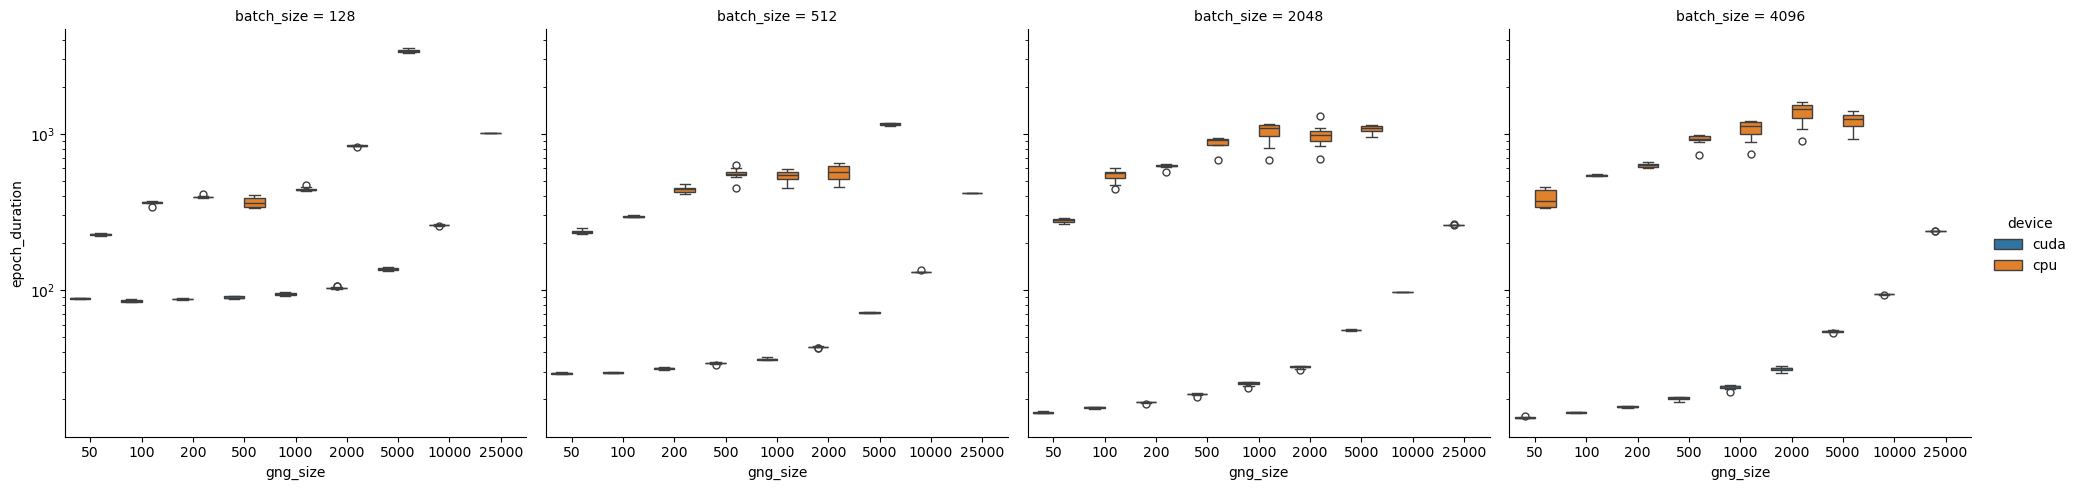

In [3]:
sns.catplot(results, x="gng_size", y="epoch_duration", hue="device", col="batch_size", kind="box", errorbar="se", log_scale=True)

Mean epoch duration* for *cuda based* GNGs, applied on Googlenews-300

In [5]:
results[results["device"]=="cuda"].groupby("gng_size").epoch_duration.mean()

gng_size
50        37.345581
100       37.182335
200       39.016538
500       41.296575
1000      44.918645
2000      52.470432
5000      79.412298
10000    145.503516
25000    480.435135
Name: epoch_duration, dtype: float64

Mean epoch duration* for *cpu based* GNGs, applied on Googlenews-300

In [6]:
results[results["device"]=="cpu"].groupby("gng_size").epoch_duration.mean()

gng_size
50       282.219033
100      435.023126
200      520.383315
500      678.852150
1000     767.586578
2000     933.762679
5000    1705.725498
Name: epoch_duration, dtype: float64

\* both measurements are performed within the Jupyter notebook, which is why significant performance differences are possible compared to a dedicated *python run.py* call. 